# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.set_option('expand_frame_repr', True)
import numpy as np
import pubchempy as pcp
from rdkit import Chem
import cirpy #for changing between identifiers
import matplotlib.pyplot as plt
import seaborn as sns

#for web integration
from googlesearch import search
import webbrowser

#for molecular drawings and descriptor calculation
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as descriptor
from rdkit.Chem import Crippen
from rdkit.Chem import AllChem
#size = (120, 120)  # Smaller figures than the default.

from sklearn import linear_model
import statsmodels.api as sm

#for progress bars
from ipywidgets import widgets, Layout
from IPython.display import display
from ipywidgets import IntProgress 
#Run this part outside of the loop - create progress bar

#max_count = len(cal_df.index.values)
#f = IntProgress(min=0, max=max_count, description='CIDs') # instantiate the bar
#display(f) # display the bar
#count = 0
    
    
#Place this part inside the loop

    #f.value += 1 # signal to increment the progress bar
    #count += 1

def try_func(list_name, function, mol):
    """Tries function on an rdkit mol object; if function throws error then np.nan
    is appended to the list - if the function succeeds then the output is appended"""
    try:    
        var = (function(mol))
        list_name.append(var)
    except:
        list_name.append(np.nan)

def bond_counter(bond_list):
    """Takes bond list constructed from RDKit mol object, returns Dataframe """
    bond_CsingleH = bond_list.count('C SINGLE H') + bond_list.count('N SINGLE C')
    bond_CsingleO = bond_list.count('C SINGLE O') + bond_list.count('O SINGLE C')
    bond_CsingleC = bond_list.count('C SINGLE C')
    bond_CsingleN = bond_list.count('C SINGLE N') + bond_list.count('N SINGLE C')
    bond_CsingleP = bond_list.count('C SINGLE P') + bond_list.count('P SINGLE C')
    bond_CsingleS = bond_list.count('C SINGLE S') + bond_list.count('S SINGLE C')
    bond_OsingleH = bond_list.count('O SINGLE H') + bond_list.count('H SINGLE O')
    bond_OsingleO = bond_list.count('O SINGLE O')
    #signle bonds to halides
    bond_CsingleF = bond_list.count('C SINGLE F') + bond_list.count('F SINGLE C')
    bond_CsingleCl = bond_list.count('C SINGLE Cl') + bond_list.count('Cl SINGLE C')
    bond_CsingleBr = bond_list.count('C SINGLE Br') + bond_list.count('Br SINGLE C')
    bond_CsingleI = bond_list.count('C SINGLE I') + bond_list.count('I SINGLE C')
    #double bonds
    bond_CdoubleO = bond_list.count('C DOUBLE O') + bond_list.count('O DOUBLE C')
    bond_CdoubleC = bond_list.count('C DOUBLE C')
    bond_CdoubleN = bond_list.count('C DOUBLE N') + bond_list.count('N DOUBLE C')
    bond_CdoubleP = bond_list.count('C DOUBLE P') + bond_list.count('P DOUBLE C')
    bond_CdoubleS = bond_list.count('C DOUBLE S') + bond_list.count('S DOUBLE C')
    #triple bonds
    bond_CtripleC = bond_list.count('C TRIPLE C')
    bond_CtripleN = bond_list.count('C TRIPLE N') + bond_list.count('N TRIPLE C')
    return [bond_CsingleH, bond_CsingleO, bond_CsingleC, bond_CsingleN,
                bond_CsingleP, bond_CsingleS, bond_OsingleH, bond_OsingleO,
                bond_CsingleF, bond_CsingleCl, bond_CsingleBr, bond_CsingleI,
                bond_CdoubleO, bond_CdoubleC, bond_CdoubleN, bond_CdoubleP, bond_CdoubleS,
                bond_CtripleC, bond_CtripleN]

def button_link(link):
    def on_button_clicked(b):
        with output:
            print("Link opening...")
            webbrowser.open(link)
    button = widgets.Button(description= '{}'.format(link),
                             layout=Layout(width='50%', height='22px'))#.split('/')[0]))
    output = widgets.Output()
    display(button)
    button.on_click(on_button_clicked)

# Pulling data out of the `.f90` file in the supplement

- By reading the `.f90` files directly into python, I can extract some data. Below I will get as much data as I can and put it into a dataframe.
- `HcpSI.f90` contains HLCs in the form $\frac{mol}{m^3Pa}$, as in the pdf supplied by Jeremy
- Some species have no data. I'll drop these columns and move on from there. 
- This leaves 4605 species with the first constant from their list
- Most species have several constants - for now I am just using the first constant in each case, as Jeremy advised
- The constants are strings, so I've pulled them apart and formed numbers from them to work with

In [3]:
file_henry = open("henry_law_dataset/output/HcpSI.f90", "r")
species_f90 = file_henry.read()
species_f90 = species_f90.split(sep="! species:")

species_list = [] ; formula_list = [] ; cas_ref_list = [] ; inchi_key_list = []
constant_list = []

for i in species_f90[1:]: #first line is ! alpha, skip this line with [1:]
    lines = i.split(sep='\n')
    #display(Math('$' + lines[1].split(sep='! formula: ')[1] + '$')) #math output
    #running the above line on the whole file slows down the notebook ALOT
    species = lines[0]
    species_list.append(species[1:])
    
    cas_ref = (lines[3].split(sep='! casrn:   ')[1])
    cas_ref_list.append(cas_ref)
        
    inchi_key = lines[4].split(sep='! inchikey: ')[1]
    inchi_key_list.append(inchi_key)
    #several constants per species - number varies per species
    #for now, using the first constant
    # TALK TO JEREMY ABOUT HOW TO APPROACH THIS
    if 'HcpSI' in lines[5]:
        constant_list.append(lines[5].split(sep='=  ')[1][0:8])
        print(lines[5])
    else:
        constant_list.append('null')
df = pd.DataFrame(species_list)
df.rename({0:'Species'}, axis=1, inplace=True)
df.set_index('Species', inplace=True)
df['CAS'] = cas_ref_list
df['Constant'] = constant_list
all_data = df.loc[df['Constant'] != 'null']

new_value_list = []
for i in range(0, len(all_data.Constant)):
    value = all_data.Constant[i]
    if type(value) == str:
        number = float(value.split(sep='E')[0])
        power = float((value.split(sep='E')[1]))
        new_value = (number*np.power(10, power))
        new_value_list.append(new_value) #check
if type(all_data.Constant[0]) == str:
    all_data['Constant'] = new_value_list

HcpSI___7782_44_7 =  1.2E-05 * EXP(   1700.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: L, ref: 2828
HcpSI__10028_15_6 =  1.0E-04 * EXP(   2800.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: L, ref: 2626
HcpSI__12385_13_6 =  2.6E-06                                  ! [mol/(m^3~Pa)] type: L, ref: 2626
HcpSI___1333_74_0 =  7.8E-06 * EXP(    530.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: L, ref: 2105
HcpSI___7782_39_0 =  7.9E-06 * EXP(    780.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: X, ref: young81a
HcpSI___3352_57_6 =  3.8E-01                                  ! [mol/(m^3~Pa)] type: L, ref: 2626
HcpSI___3170_83_0 =  6.8E+00                                  ! [mol/(m^3~Pa)] type: L, ref: 2626
HcpSI___7722_84_1 =  9.1E+02 * EXP(   6600.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: L, ref: 2828
HcpSI___7727_37_9 =  6.4E-06 * EXP(   1600.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: L, ref: 2828
HcpSI___7664_41_7 =  5.9E-01 * EXP(   4200.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: L, ref: 2626
HcpSI___7782_79_

HcpSI_____90_84_6 =  4.3E+01                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI__18559_94_9 =  1.5E+10                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI___2475_45_8 =  4.7E+01                                  ! [mol/(m^3~Pa)] type: V, ref: 3088
HcpSI____119_90_4 =  2.1E+05                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI__22839_47_0 =  3.9E+12                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI____973_21_7 =  6.2E+02                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI___1982_49_6 =  1.5E+05                                  ! [mol/(m^3~Pa)] type: V, ref: 3088
HcpSI__33629_47_9 =  2.0E+00                                  ! [mol/(m^3~Pa)] type: V, ref: 3088
HcpSI___1643_20_5 =  1.5E+05                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI____117_79_3 =  1.1E+05                                  ! [mol/(m^3~Pa)] type: V, ref: 3088
HcpSI_____82_28_0 = 

HcpSI_____75_62_7 =  2.7E-02                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI____124_48_1 =  8.6E-03 * EXP(   5500.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: L, ref: 2626
HcpSI____107_04_0 =  1.1E-02                                  ! [mol/(m^3~Pa)] type: V, ref: 642
HcpSI_____75_81_0 =  6.2E-02                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI____109_70_6 =  3.9E-02                                  ! [mol/(m^3~Pa)] type: Q, ref: 3088
HcpSI_____96_12_8 =  9.7E-02 * EXP(   7100.*(1./298.15-1./T)) ! [mol/(m^3~Pa)] type: M, ref: 2891
HcpSI_____87_84_3 =  1.0E+01                                  ! [mol/(m^3~Pa)] type: Q, ref: 2995
HcpSI__CAS-77 =  3.4E+00                                  ! [mol/(m^3~Pa)] type: Q, ref: 2995
HcpSI__CAS-79 =  1.1E+00                                  ! [mol/(m^3~Pa)] type: Q, ref: 2995
HcpSI____106_39_8 =  6.8E-03                                  ! [mol/(m^3~Pa)] type: V, ref: 479
HcpSI__13075_01_9 =  4.1E-02  

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Curating the dataset
- Look through dataset - mark species which have wide variation in HLC
- Use the `type` attribute of each constant - remove constants marked incorrect.
    - Only one value marked incorrect - hydrogen chloride, which isn't used in my training set

In [5]:
file = open("henry_law_dataset/output/HcpSI.f90", "r")
species_f90 = (file.read().split(sep="! species:"))
species_list = [] 
constant_list = []

for i in species_f90[1:]: #first line is ! alpha, skip this line with [1:]
    const_per_line = [] #list for each species' constants
    species = i.split(sep='\n')[0]
    species_list.append(species)
    hcpsi_lines = (i.split(sep='\n')[5:])
    for j in range(0, len(hcpsi_lines)):
        if 'HcpSI' in hcpsi_lines[j]:
            const_per_line.append(hcpsi_lines[j].split(sep='=  ')[1][0:8])
        else:
            pass
    
    if 'HcpSI' in i:
        new_value_list = []
        for const in const_per_line:
            if type(const) == str:
                number = float(const.split(sep='E')[0])
                power = float((const.split(sep='E')[1]))
                new_value = (number*np.power(10, power))
            new_value_list.append(new_value) #check
        constant_list.append(new_value_list)
    else:
        constant_list.append(np.nan)

In [18]:
min_list = []; max_list = []; mean_list = []; median_list = []; num_constants_list = []
for clist in constant_list:
    min_list.append(np.min(clist))
    
    max_list.append(np.max(clist))
    
    mean_list.append(np.mean(clist))
    
    median_list.append(np.median(clist))
    if type(clist) == list:
        num_constants_list.append(len(clist))
    else:
        num_constants_list.append(0)
const_list_df = pd.DataFrame(species_list)
const_list_df.rename({0:'Species'}, axis=1, inplace=True)
const_list_df['Num'] = num_constants_list
const_list_df['min'] = min_list    
const_list_df['max'] = max_list    
const_list_df['mean'] = mean_list    
const_list_df['median'] = median_list
const_list_df['max-min'] = np.array(max_list) - np.array(min_list)

const_list_df.head()

,Species,Num,min,max,mean,median,max-min
0,oxygen,14,0.000012,0.000013,0.000013,0.000013,1.000000e-06
1,ozone,13,0.000001,0.000130,0.000102,0.000110,1.290000e-04
2,hydrogen atom,2,0.000003,0.000003,0.000003,0.000003,0.000000e+00
3,hydrogen,7,0.000008,0.000008,0.000008,0.000008,2.000000e-07
4,deuterium,1,0.000008,0.000008,0.000008,0.000008,0.000000e+00


In [20]:
total = 0
for i in range(0, len(const_list_df)): #count total number of constants to compare to a_curating_dataset
    num_constants = const_list_df.iloc[i].Num
    if num_constants != np.nan:
        total = total + num_constants
print(total)

16213


## Dropping species with constants which vary by more than 1
By dropping these species, I hope to sort some of the outliers I have present

In [184]:
varying_const_df = const_list_df[const_list_df['max-min'] > 1]
varying_const_df.set_index('Species', inplace=True)
to_drop = list(varying_const_df.index)

In [185]:
drop_list = []
for i in to_drop:
    drop_list.append(i[1:])
drop_list

['hypochlorous acid',
 '1-benzyl-2-(2-methylbenzyl)benzene',
 '2,5-dibenzyltoluene',
 'diphenylmethane',
 '$o$-terphenyl',
 '$p$-terphenyl',
 '9,10-dimethylanthracene',
 'pyrene',
 'benzo[$jk$]fluorene',
 'dibenz[$a,j$]anthracene',
 'methanol',
 'ethanol',
 '1-propanol',
 '2-propanol',
 '1-butanol',
 '2-methyl-2-propanol',
 'cyclopentanol',
 'cyclohexanol',
 'cycloheptanol',
 'cyclododecanol',
 '2-propen-1-ol',
 '2-propyn-1-ol',
 '2-methyl-3-butyn-2-ol',
 '2,4,6-trimethylphenol',
 '3,4,5-trimethylphenol',
 '1-hydroxy-2-ethylbenzene',
 '2,3,6-trimethylphenol',
 '4-(1,1,3,3-tetramethylbutyl)-phenol',
 '4-phenyl-1-butanol',
 'octanal',
 'propenal',
 '3-phenyl-2-propenal',
 'cyclohexanone',
 'phenyl ethyl ketone',
 '4-methoxy-4-methyl-2-pentanone',
 '4-methoxyphenyl methyl ketone',
 '3,5,5-trimethyl-2-cyclohexen-1-one',
 'isopropyl phenyl ketone',
 '1-(2,3-dihydro-1,1,2,3,3,6-hexamethyl-1H-inden-5-yl)ethanone',
 'celestolide',
 '1-[2,3-dihydro-1,1,2,6-tetramethyl-3-(1-methylethyl)-1H-inden

# Getting identifiers
## Getting SMILES strings
- Below I'll grab SMILES strings for each compound. 
- As this process takes a while, The resultant dataframe will be exported to .csv for later. 
- `cirpy` library used to change between CAS and SMILES. 
- SMILES strings will be useful in picking out functional groups, and are used in further cells to grab descriptors and SMARTS strings.

In [41]:
max_count = len(all_data.CAS)
f = IntProgress(min=0, max=max_count, description='Progress') # instantiate the bar
display(f) # display the bar
count = 0
    
    
#Place this part inside the loop
answer = input('Run this script? Takes a while (y/n) >')
if 'SMILES' in list(all_data) or answer == 'n':
    print("SMILES already grabbed")
    f.value += len(all_data.CAS)
else:
    smiles_list = []
    for cas_ref in all_data.CAS:
        f.value += 1 # signal to increment the progress bar
        count += 1
        smiles_list.append(cirpy.resolve(cas_ref, 'smiles'))
    all_data['SMILES'] = smiles_list

IntProgress(value=0, description='Progress', max=4605)

Run this script? Takes a while (y/n) >y


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Getting SMARTS strings
- Using `RDKit.Chem` to convert SMILES strings into SMARTS strings. 
- This will make searching by atom type easier - SMARTS in `RDKit` use atomic number rather than symbol to denote elements
- The dataframe is then exported to save doing this later

In [48]:
smarts_list = []
max_count = len(all_data.index.values)
f = IntProgress(min=0, max=max_count, description='Progress') # instantiate the bar
display(f) # display the bar
count = 0

for species in all_data.index:
    #smiles = carbons.SMILES.iloc(i)
    #print(smiles)
    try:
        mol = Chem.MolFromSmiles(all_data.loc[species].SMILES)
        smarts = Chem.MolToSmarts(mol)
        smarts_list.append(smarts)
    except Exception as e:
        print(e)
        smarts_list.append('')

    f.value += 1 # signal to increment the progress bar
    count += 1
all_data['SMARTS'] = smarts_list

IntProgress(value=0, description='Progress', max=4605)

Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmarts(NoneType)
did not match C++ signature:
    MolToSmarts(class RDKit::ROMol {lvalue} mol, bool isomericSmiles=True)
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmarts(NoneType)
did not match C++ signature:
    MolToSmarts(class RDKit::ROMol {lvalue} mol, bool isomericSmiles=True)
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmarts(NoneType)
did not match C++ signature:
    MolToSmarts(class RDKit::ROMol {lvalue} mol, bool isomericSmiles=True)
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of typ

No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of

No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of

No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of

No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of

No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType
No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
all_data.to_csv("DATA/all_data_smiles_smarts.csv")

In [107]:
name_data = pd.read_csv('DATA/all_data_smiles_smarts.csv')
name_data.drop(['Constant', 'SMARTS'], inplace=True, axis=1)
name_data.to_csv('name_list.csv')

# Use RDKit to calculate descriptors using SMILES
- `rdkit.Chem.rdMolDescriptors` (imported as `descriptor`) gives:
    - Exact molecular weight `wt`
    - Fraction of carbons that are sp3 hybridised `fraction_sp3`
    - Number aliphatic rings `ali_homo_rings`
    - Number aliphatic rings `ali_hetero_rings`
    - Number aromatic rings (heterocycle) `aro_hetero_rings`
    - Number aromatic rings (homocycle) `aro_homo_rings`
    - Number of amide bonds `amide_bonds`
    - Number of hydrogen bond acceptors `hba`
    - Number of hydrogen bond donors `hbd`
    - Total polar surface area [TPSA](https://en.wikipedia.org/wiki/Polar_surface_area) `tpsa`
    
- `rdkit.Chem.Crippen` gives a calculation of Wildman-Crippen LogP values by atom contributions using the same method as [this paper](https://pubs.acs.org/doi/pdf/10.1021/ci990307l)

In [172]:
data = pd.read_csv("DATA/all_data_smiles_smarts.csv")
all_data = data.set_index('Species')

In [216]:
wt_list = [] ; logp_list = [] ; fraction_sp3_list = []
ali_homo_rings_list = [] ; ali_hetero_rings_list = [] 
aro_homo_rings_list = [] ; aro_hetero_rings_list = []
amide_bonds_list = [] ; hba_list = [] ; hbd_list = []
tpsa_list = []

for i in range(0, len(all_data)):
    smiles = (all_data.SMILES[i])
    try:
        mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    except Exception as e:
        pass
    
    
    if type(mol) != str and type(mol) != None:
        try_func(wt_list, descriptor.CalcExactMolWt, mol)
        try_func(logp_list, Crippen.MolLogP, mol)
        try_func(fraction_sp3_list, descriptor.CalcFractionCSP3, mol)
        try_func(ali_homo_rings_list, descriptor.CalcNumAliphaticCarbocycles, mol)
        try_func(ali_hetero_rings_list, descriptor.CalcNumAliphaticHeterocycles, mol)
        try_func(aro_homo_rings_list, descriptor.CalcNumAromaticCarbocycles, mol)
        try_func(aro_hetero_rings_list, descriptor.CalcNumAromaticHeterocycles, mol)
        try_func(amide_bonds_list, descriptor.CalcNumAmideBonds, mol)
        try_func(hba_list, descriptor.CalcNumHBA, mol)
        try_func(hbd_list, descriptor.CalcNumHBD, mol)
        try_func(tpsa_list, descriptor.CalcTPSA, mol)

all_data['wt'] = wt_list
all_data['logp'] = logp_list
all_data['fraction_sp3'] = fraction_sp3_list
all_data['ali_homo_rings'] = ali_homo_rings_list
all_data['ali_hetero_rings'] = ali_hetero_rings_list
all_data['amide_bonds'] = amide_bonds_list
all_data['aro_homo_rings'] = aro_homo_rings_list
all_data['aro_hetero_rings'] = aro_hetero_rings_list
all_data['hba'] = hba_list
all_data['hbd'] = hbd_list
all_data['tpsa'] = tpsa_list

`rdkit.AllChem` gives molecular volume calculation from SMILES

In [219]:
max_count = len(all_data)
f = IntProgress(min=0, max=max_count, description='Progress') # instantiate the bar
display(f) # display the bar
count = 0
choice = input("Run this script? takes while (y/n)")
if choice == 'y':
    volume_list = []
    for i in range(0, len(all_data)):
        f.value += 1 # signal to increment the progress bar
        count += 1
        smiles = (all_data.SMILES[i])
        try:
            mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
            AllChem.EmbedMolecule(mol)
        except Exception as e:
            pass
    
        if type(mol) != str and type(mol) != None:
            try_func(volume_list, AllChem.ComputeMolVolume, mol)


    all_data['volume'] = volume_list
else:
    print('Volumes not fetched')

IntProgress(value=0, description='Progress', max=4605)

Run this script? takes while (y/n)n
Volumes not fetched


## Getting bond information
`rdkit.Chem.rdchem` lets us delve into the molecule and pull out atom and bond information.

In [278]:
CsingleH_list = [] ;  CsingleO_list = [] ;  CsingleC_list = []
CsingleN_list = [] ;  CsingleP_list = [] ;  CsingleS_list = [] 
OsingleH_list = [] ;  OsingleO_list = [] ;  CsingleF_list = []
CsingleCl_list = []; CsingleBr_list = [] ;  CsingleI_list = []
CdoubleO_list = [] ;  CdoubleC_list = [] ;  CdoubleN_list = []
CdoubleP_list = [] ;  CdoubleS_list = []
CtripleC_list = [] ;  CtripleN_list = []
for i in range(0, len(all_data)):
    smiles = all_data.SMILES[i]
    bond_list = []
    try:
        mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    except Exception as e:
        pass
    
    
    if type(mol) != str and type(mol) != None:
        bonds = mol.GetBonds() #get list of bond objects
        for i in bonds:
            atom1 = i.GetBeginAtom() #first atom in bond
            atom1_num = atom1.GetSymbol()
            atom2 = i.GetEndAtom() #other atom in bond
            atom2_num = atom2.GetSymbol()
            bond_type_obj = i.GetBondType()
            bond_list.append(atom1_num + " " + str(bond_type_obj) + " " + atom2_num) #list of bonds in the molecule
        count_bond_list = bond_counter(bond_list)
        CsingleH_list.append(count_bond_list[0])
        CsingleO_list.append(count_bond_list[1])
        CsingleC_list.append(count_bond_list[2])
        CsingleN_list.append(count_bond_list[3])
        CsingleP_list.append(count_bond_list[4])
        CsingleS_list.append(count_bond_list[5])
        OsingleH_list.append(count_bond_list[6])
        OsingleO_list.append(count_bond_list[7])
        CsingleF_list.append(count_bond_list[8])
        CsingleCl_list.append(count_bond_list[9])
        CsingleBr_list.append(count_bond_list[10])
        CsingleI_list.append(count_bond_list[11])
        CdoubleO_list.append(count_bond_list[12])
        CdoubleC_list.append(count_bond_list[13])
        CdoubleN_list.append(count_bond_list[14])
        CdoubleP_list.append(count_bond_list[15])
        CdoubleS_list.append(count_bond_list[16])
        CtripleC_list.append(count_bond_list[17])
        CtripleN_list.append(count_bond_list[18])
        
all_data['C-H'] = CsingleH_list
all_data['C-O'] = CsingleO_list
all_data['C-C'] = CsingleC_list
all_data['C-N'] = CsingleN_list
all_data['C-P'] = CsingleP_list
all_data['C-S'] = CsingleS_list
all_data['O-H'] = OsingleH_list
all_data['O-O'] = OsingleO_list
all_data['C-F'] = CsingleF_list
all_data['C-Cl'] = CsingleCl_list
all_data['C-Br'] = CsingleBr_list
all_data['C-I'] = CsingleI_list
all_data['C=O'] = CdoubleO_list
all_data['C=C'] = CdoubleC_list
all_data['C=N'] = CdoubleN_list
all_data['C=P'] = CdoubleP_list
all_data['C=S'] = CdoubleS_list
all_data['C#C'] = CtripleC_list
all_data['C#N'] = CtripleN_list

## Shape descriptors
`rd.Chem.Descriptors3D` gets ["Descriptors derived from a molecule’s 3D structure"](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html).

- As we are dealing with the 3D co-ordinates for atoms in each molecule, we may need to consider optimization to find the correct conformers. 
- Optimized using `Chem.rdForceFieldHelpers.MMFFOptimizeMolecule`
- Lee recommended MMFF for a set of organics

Descriptors:
- Asphericity `asph`
- Eccentricity `ecce`
- Inertial shape factor `isf`
- NPR1 / NPR2 `npr1 / npr2`
- PMI1 / PMI2 / PMI3 `pmi1 / pmi2 / pmi3`
- Radius of gyration `rog`
- Spheriocity index `si`

In [74]:
asph_list = [] ; ecce_list = [] ; isf_list = [] ; npr1_list = [] ; npr2_list = [] 
pmi1_list = [] ; pmi2_list = [] ; pmi3_list = [] ; rog_list = [] ; si_list = [] 


max_count = len(all_data.index.values)
f = IntProgress(min=0, max=max_count, description='Progress') # instantiate the bar
display(f) # display the bar
count = 0
    
    
#Place this part inside the loop

   

from rdkit.Chem import Descriptors3D
for i in range(0, len(all_data)):
    name = (all_data.index[i])
    smiles = (all_data.iloc[i].SMILES)
    try:
        mol = Chem.AddHs(Chem.MolFromSmiles(smiles)) #add Hs to get real value (with implicit Hs)
        AllChem.EmbedMolecule(mol) #embed to calc 3D descriptors
        Chem.rdForceFieldHelpers.MMFFOptimizeMolecule(mol) #optimize
    except:
        mol = None
    try_func(asph_list, Descriptors3D.Asphericity, mol)
    try_func(ecce_list, Descriptors3D.Eccentricity, mol)
    try_func(isf_list, Descriptors3D.InertialShapeFactor, mol)
    try_func(npr1_list, Descriptors3D.NPR1, mol)
    try_func(npr2_list, Descriptors3D.NPR2, mol)
    try_func(pmi1_list, Descriptors3D.PMI1, mol)
    try_func(pmi2_list, Descriptors3D.PMI2, mol)
    try_func(pmi3_list, Descriptors3D.PMI3, mol)
    try_func(rog_list, Descriptors3D.RadiusOfGyration, mol)
    try_func(si_list, Descriptors3D.SpherocityIndex, mol)
    f.value += 1 # signal to increment the progress bar
    count += 1

IntProgress(value=0, description='Progress', max=4605)

In [78]:
all_data['asph'] = asph_list
all_data['ecce'] = ecce_list
all_data['isf'] = isf_list
all_data['npr1'] = npr1_list
all_data['npr2'] = npr2_list
all_data['pmi1'] = pmi1_list
all_data['pmi2'] = pmi2_list
all_data['pmi3'] = pmi3_list
all_data['rog'] = rog_list
all_data['si'] = si_list

In [79]:
all_data.head()

,CAS,Constant,SMILES,SMARTS,wt,logp,fraction_sp3,ali_homo_rings,ali_hetero_rings,amide_bonds,aro_homo_rings,aro_hetero_rings,hba,hbd,volume,tpsa,C-H,C-O,C-C,C-N,C-P,C-S,O-H,O-O,C-F,C-Cl,C-Br,C-I,C=O,C=C,C=N,C=P,C=S,C#C,C#N,asph,ecce,isf,npr1,npr2,pmi1,pmi2,pmi3,rog,si
Species,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
oxygen,7782-44-7,0.000012,O=O,[#8]=[#8],31.989829,0.0670,0.0,0,0,0,0,0,2,0,30.488,34.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,0.0,10.427614,10.427614,0.570862,0.0
ozone,10028-15-6,0.000100,O=[O]=O,NaN,31.989829,0.0670,0.0,0,0,0,0,0,2,0,30.488,34.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hydrogen atom,12385-13-6,0.000003,[H][H],[H]-[H],2.015650,0.2460,0.0,0,0,0,0,0,0,0,10.240,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.245556,0.245556,0.349004,0.0
hydrogen,1333-74-0,0.000008,[H],[H],1.007825,0.1125,0.0,0,0,0,0,0,0,0,7.160,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
deuterium,7782-39-0,0.000008,[2H][2H],[2H]-[2H],4.028204,0.2460,0.0,0,0,0,0,0,0,0,10.136,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.501522,0.501522,0.352849,0.0


### Export dataframe

In [80]:
all_data.to_csv("DATA/all_data_descriptors_bonds.csv")

In [77]:
data = pd.read_csv("DATA/all_data_descriptors_bonds.csv")
all_data = data.set_index('Species')

# Split into organic and inorganic
>Organic set will contain hydrocarbons and their derivatives without any heavy metals, inorganic set will contain the remaining species.

In [60]:
carbons_list = [] ; no_carbons_list = []
for i in range(0, len(all_data)):
    smarts = all_data.SMARTS.iloc[i]
    name = all_data.index[i]
    if type(smarts) == str:
        if '#6' in smarts:
            carbons_list.append(i)
        else:
            no_carbons_list.append(i)

In [61]:
organics = all_data.iloc[carbons_list]
#organics.set_index('Species', inplace=True)
inorganics = all_data.iloc[no_carbons_list]
drop_list = []

#for i in range(0, 16):
#    drop_list.append(organics.index[i])
#drop_list.append(organics.index[390])
#drop_list.append(organics.index[391])
#drop_list

metals_removal_list = ["4,4',4''-methanetriyltris(N,N-diethylaniline)", 'Hg', 'Se', 'As', 'Zn', 'Si', 'Na', 'Al', 'Pb', 'Sn']
for i in range(0, len(organics.index.values)):
    for metal in metals_removal_list:
        if metal in organics.SMILES[i]:
            drop_list.append(organics.index[i])
            drop_list

organics.drop("4,4',4''-methanetriyltris(N,N-diethylaniline)", inplace=True, axis=0)
organics.drop(labels=drop_list, inplace=True, axis=0)

### Export organic and inorganic species as a seperate dataframes

In [62]:
organics.to_csv("DATA/organics.csv")
inorganics.to_csv("DATA/inorganics.csv")

In [2]:
import pandas as pd

In [3]:
data1 = pd.read_csv("DATA/organics.csv")
organics = data1.set_index('Species')
data2 = pd.read_csv("DATA/inorganics.csv")
inorganics = data2.set_index('Species')

In [4]:
len(organics)

4020

In [180]:
org_filtered = organics.copy()
for species in drop_list:
    if species in organics.index:
        org_filtered.drop(species, axis=0, inplace=True)

In [181]:
print(len(organics), len(org_filtered))

4020 3809


In [182]:
org_filtered.to_csv('DATA/org_removed_wild_ones.csv')

# WIDGET Browse the organic species by molecules

In [63]:
@widgets.interact
def show_mol(Mol = organics.index):
    m = Chem.MolFromSmiles(organics.loc[Mol].SMILES)
    fig = Draw.MolToMPL(m, size =(240, 240))
    data = pd.DataFrame(organics.loc[Mol]).T
    data.drop(['SMILES', 'SMARTS'], inplace=True, axis=1)
    data.rename(mapper={'Unnamed: 0':'Index'}, inplace=True, axis=1)
    display(data, "### SMILES ###:  {}".format(organics.loc[Mol].SMILES), "### SMARTS ###:  {}".format(organics.loc[Mol].SMARTS))
    for link in search(Mol, tld = 'co.uk', lang='en', num = 3, stop=3):
        button_link(link)

interactive(children=(Dropdown(description='Mol', options=('methane', 'ethane', 'propane', 'butane', '2-methyl…

## Split off simple linear hydrocarbons

In [99]:
linear_hc_list = []
for i in range(0, 50):
    smiles = ('C' * i)
    for j in range(0, len(organics)):
        species_smiles = organics.iloc[j].SMILES
        if species_smiles == smiles:
            linear_hc_list.append(j)
linear_hydrocarbons = organics.iloc[linear_hc_list]

In [100]:
linear_hydrocarbons.to_csv('DATA/linear_hydrocarbons.csv')

# Getting set of `.mol` files for use with DRAGON

In [32]:
for i in range(0, len(organics)):
    name = (organics.index[i])
    smiles = (organics.iloc[i].SMILES)
    mol = Chem.MolFromSmiles(smiles)
    try:
        Chem.rdmolfiles.MolToMolFile(mol, "mol_files/%s.mol" %name)
    except:
        if "}" in name:
            name = str(i)
            Chem.rdmolfiles.MolToMolFile(mol, "mol_files/%s.mol" %name)

# Visualisation
## Use histograms to view data distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002930225BDA0>,
      dtype=object)

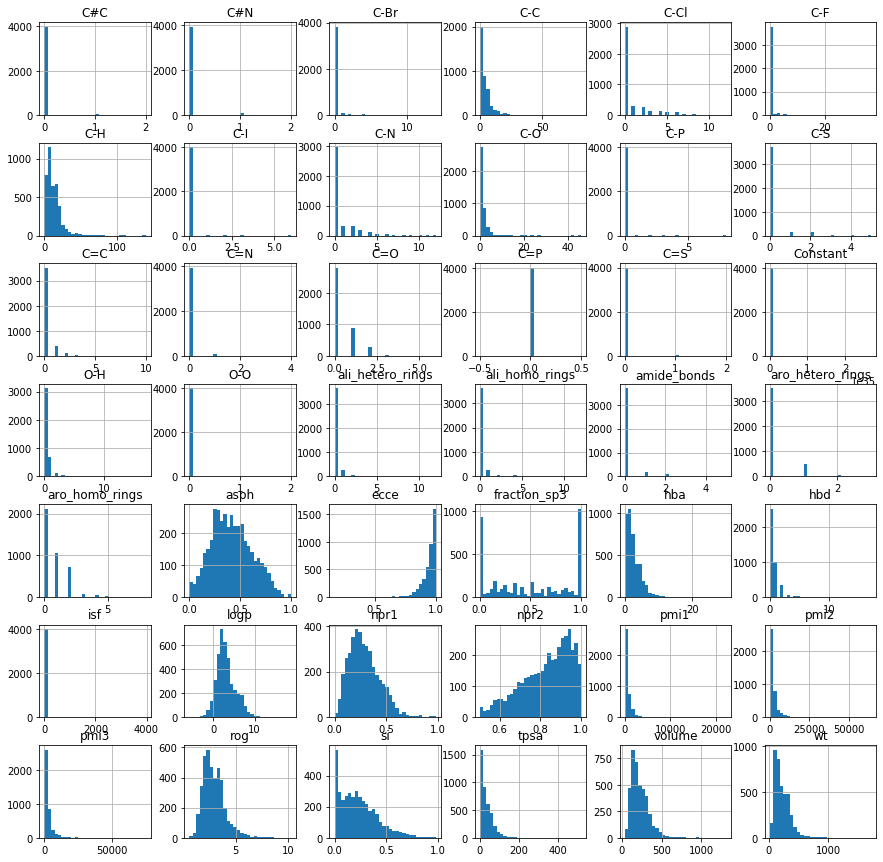

In [71]:
display(organics.hist(figsize=(15, 15), bins=30))

In [66]:
organics_plot = organics.drop(['CAS', 'SMILES', 'SMARTS'], axis=1) #remove string columns
#organics_plot.drop("4,4',4''-methanetriyltris(N,N-diethylaniline)", inplace=True, axis=0)

In [67]:
len(organics_plot)

4020

In [101]:
var_list = list(organics_plot)
label_style = dict(size=17, color='blue')
ax_style = dict(fontsize=20, color='black')
title_style = dict(size=25, color='black')

@widgets.interact(Variable = var_list, Labels = False)

def plot_henry_graph(Variable = 'wt', Labels = False):
    df = organics_plot
        
    label_style = dict(size=17, color='blue')
    ax_style = dict(fontsize=20, color='black')
    title_style = dict(size=25, color='black')
    
    fig, ax = plt.subplots(figsize=(20, 10))
    y = np.log(np.array(df.Constant))
    x = np.array(np.array(df[Variable]))
    
    try:
        line = sns.regplot(x, y, marker='x')
    except Exception as e:
        print(e, 'This data isn\'t available yet / can\'t be plotted')

    #if Labels == True:
        #for line in range(0, len(df.index)):
            #plot.text(df[Variable].iloc[line], np.log(np.array(df.Constant.iloc[line])),
                      #df.index[line], **label_style)
    else:
        pass
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('$ln(H^{cp})$', **ax_style)
    ax.set_xlabel('Property', **ax_style)
    plt.title('$ln(H^{cp})$ against %s for %s' % (Variable, "organics"), **title_style)

interactive(children=(Dropdown(description='Variable', index=1, options=('Constant', 'wt', 'logp', 'fraction_s…

PLOT EXPECTED AGAINST ACTUAL FROM MLR MODEL



## Multiple linear regression
>think LCAO, just with descriptors

Using organics set, with any nan-containing species dropped.

In [26]:
organics_reg = organics_plot.dropna(axis=0, how='any')
print(len(organics_plot), len(organics_reg))
X = organics_reg.drop('Constant', axis=1)
Y = np.log(organics_reg.Constant)

#sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print("Intercept:\t", regr.intercept_, "\n Coefficients:\t", regr.coef_)

#statsmodels
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
print(model.summary())

4020 4013
Intercept:	 -8.013269622731231 
 Coefficients:	 [-2.95830475e-02 -2.45298420e+00 -3.96975633e-01  2.64714396e+00
  2.93583332e+00 -8.36672018e-01  1.00972440e-01  2.05872724e+00
 -6.76846163e-01  2.36942706e+00  1.02997663e-01  5.74230277e-02
  1.27903367e-01 -3.87479766e-01 -1.07764591e+00  9.19358684e-02
  2.86310843e-01  5.30096682e-01  1.14140363e+00 -1.11538888e+00
 -4.68976793e-01  4.90548072e-01  2.48846507e+00  3.80207139e+00
  2.03132305e+00 -9.83986992e-01  7.08167247e-01 -4.44089210e-16
 -1.60057779e+00 -1.19629822e+00  2.59201402e+00]


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:               Constant   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     499.3
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:49:40   Log-Likelihood:                -11768.
No. Observations:                4013   AIC:                         2.360e+04
Df Residuals:                    3982   BIC:                         2.379e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.0133      0.422  